In [30]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import kpss

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Preparação

In [43]:
us_change = pd.read_csv("data/us_change.csv")
us_change
forecast_steps = 20

data = us_change["Consumption"][:-forecast_steps]
covariables = us_change[["Income", "Production", "Savings", "Unemployment"]][:-forecast_steps]

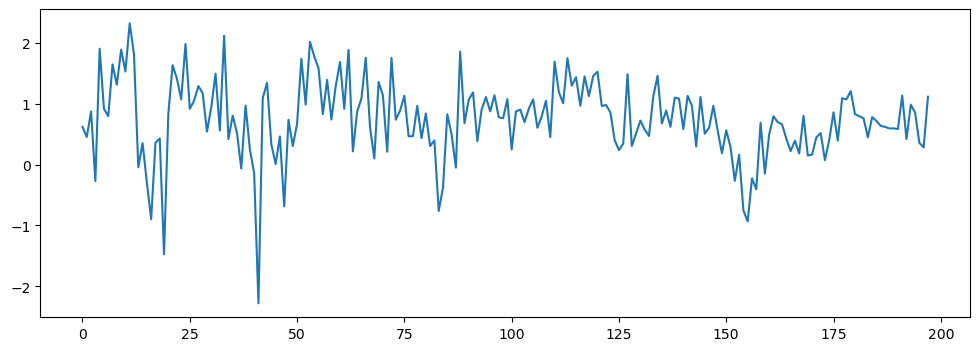

In [44]:
plt.figure(figsize=(12,4))
plt.plot(us_change["Consumption"])

## Testes para stacionariedade 

In [45]:
# KPSS test
kpss_test = kpss(data, regression='c')  # 'c' for constant trend; use 'ct' for linear trend

# Results
print("KPSS Statistic:", kpss_test[0])
print("p-value:", kpss_test[1])
print("Number of Lags:", kpss_test[2])
print("Critical Values:", kpss_test[3])

# Interpretation
if kpss_test[1] < 0.05:
    print("Reject the null hypothesis: The series is non-stationary.")
else:
    print("Fail to reject the null hypothesis: The series is stationary.")

KPSS Statistic: 0.24964131203487847
p-value: 0.1
Number of Lags: 7
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
Fail to reject the null hypothesis: The series is stationary.


/var/folders/06/j3fz87tn3q9fvnw3dfs1ptjr0000gn/T/ipykernel_26552/3692453879.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_test = kpss(data, regression='c')  # 'c' for constant trend; use 'ct' for linear trend


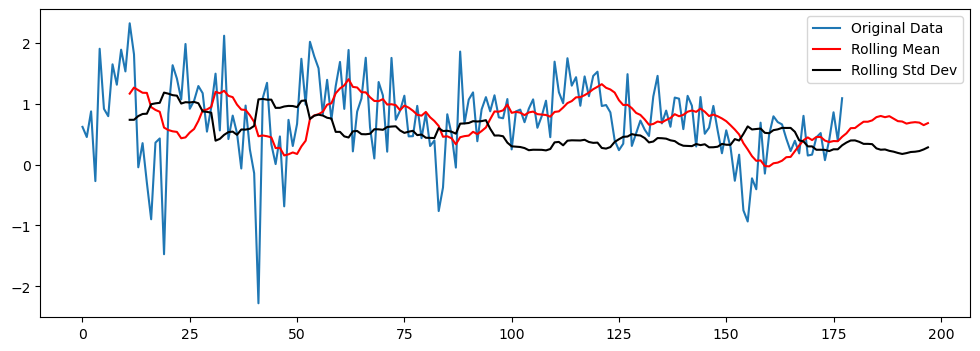

In [46]:
data_rolling_mean = us_change["Consumption"].rolling(window=12).mean()
data_rolling_std = us_change["Consumption"].rolling(window=12).std()

plt.figure(figsize=(12, 4))
plt.plot(data, label='Original Data')
plt.plot(data_rolling_mean, label='Rolling Mean', color='red')
plt.plot(data_rolling_std, label='Rolling Std Dev', color='black')
plt.legend()
plt.show()

Conclusão: A série provavelmente é estacionária.

## ARIMA

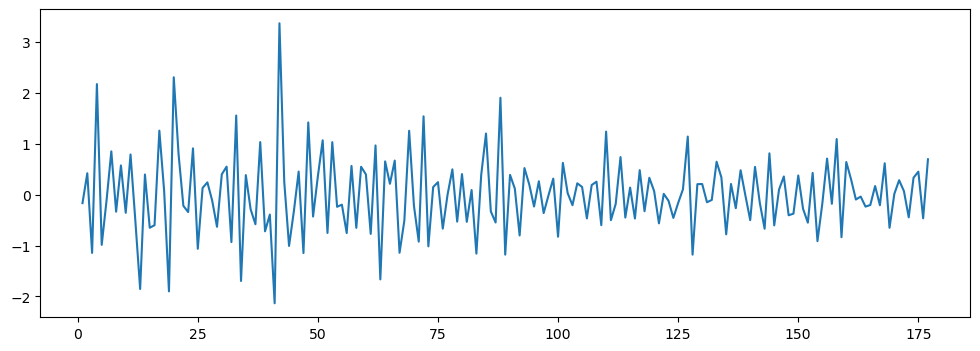

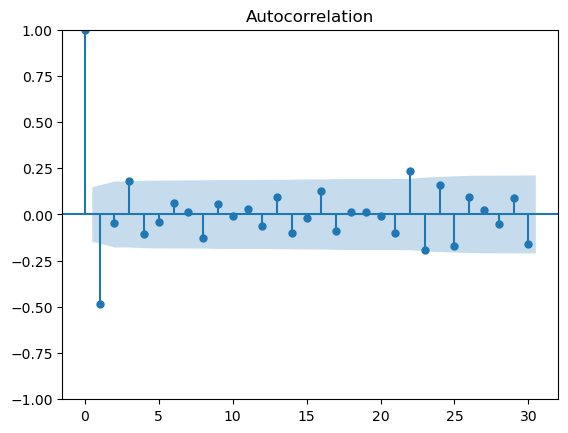

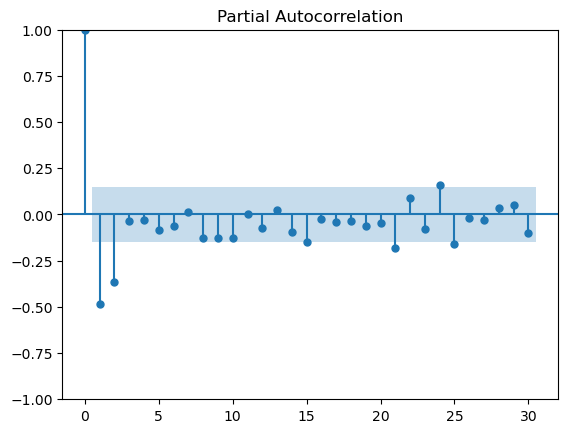

In [61]:
data_diff = data.diff().dropna()

plt.figure(figsize=(12,4))
plt.plot(data_diff)

plot_acf(data_diff, lags=30)
plot_pacf(data_diff, lags=30, method='ywm')
plt.show()

/Users/otaviomatos/mambaforge/envs/torch/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/otaviomatos/mambaforge/envs/torch/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/otaviomatos/mambaforge/envs/torch/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:            Consumption   No. Observations:                  178
Model:                 ARIMA(3, 1, 2)   Log Likelihood                -161.593
Date:                Fri, 22 Nov 2024   AIC                            335.186
Time:                        13:48:08   BIC                            354.243
Sample:                             0   HQIC                           342.914
                                - 178                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0523      0.278      0.188      0.851      -0.493       0.597
ar.L2          0.2103      0.090      2.342      0.019       0.034       0.386
ar.L3          0.2716      0.087      3.106      0.0

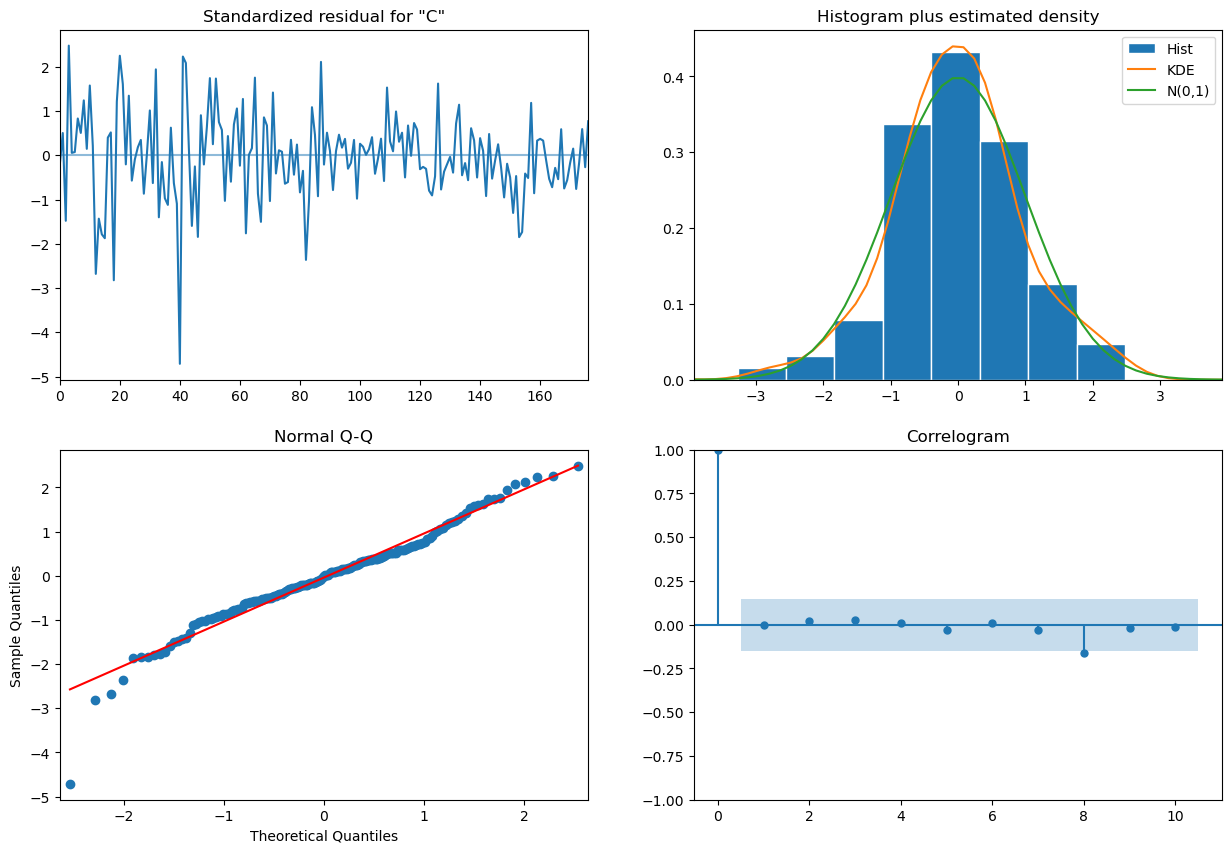

In [62]:
model = ARIMA(data, order=(3,1,2))
results = model.fit()


print(results.summary())
results.plot_diagnostics(figsize=(15, 10))
plt.show()

### Residuals

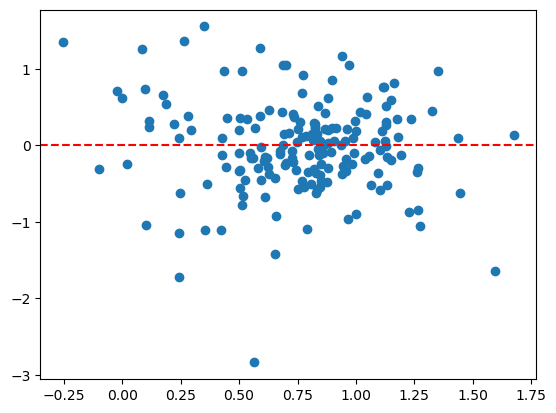

In [63]:
plt.scatter(results.fittedvalues, results.resid)
plt.axhline(0, color="red", linestyle="--")
plt.show()

In [64]:
# Teste de Ljung-Box
ljung_box_results = acorr_ljungbox(results.resid, lags=[10], return_df=True)
print(ljung_box_results)

     lb_stat  lb_pvalue
10  5.463712   0.858131


## SARIMAX

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.15525D-01    |proj g|=  1.23825D+00

At iterate    5    f=  3.10311D-01    |proj g|=  1.10622D+00

At iterate   10    f=  3.07087D-01    |proj g|=  2.16560D+00

At iterate   15    f=  2.95925D-01    |proj g|=  5.70634D-01

At iterate   20    f=  2.88556D-01    |proj g|=  8.80471D-01

At iterate   25    f=  2.87071D-01    |proj g|=  3.54664D-01

At iterate   30    f=  2.85837D-01    |proj g|=  2.49859D-02

At iterate   35    f=  2.84040D-01    |proj g|=  4.23862D-01

At iterate   40    f=  2.83175D-01    |proj g|=  3.11280D-02

At iterate   45    f=  2.82637D-01    |proj g|=  1.92695D-01

At iterate   50    f=  2.80077D-01    |proj g|=  4.36578D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.
/Users/otaviomatos/mambaforge/envs/torch/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


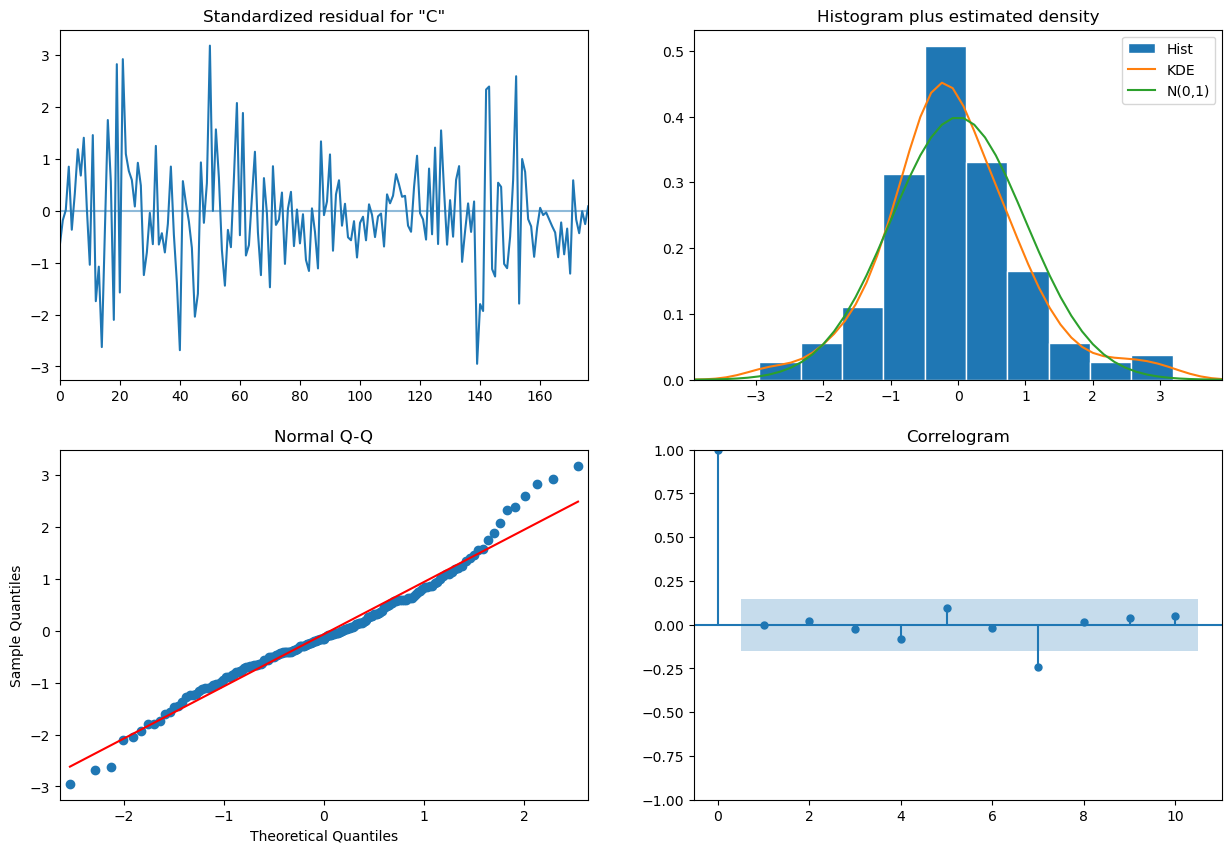

In [65]:
model_x = SARIMAX(data, exog=covariables, order = (3,1,2))
model_x_fit = model_x.fit()

print(model_x_fit.summary())
model_x_fit.plot_diagnostics(figsize=(15, 10))
plt.show()

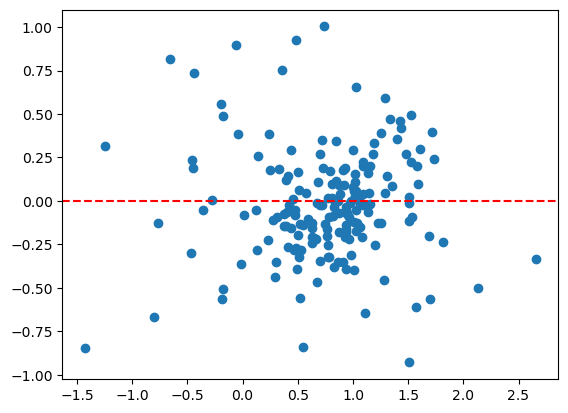

In [66]:
plt.scatter(model_x_fit.fittedvalues, model_x_fit.resid)
plt.axhline(0, color="red", linestyle="--")
plt.show()

In [67]:
# Teste de Ljung-Box
ljung_box_results = acorr_ljungbox(model_x_fit.resid, lags=[10], return_df=True)
print(ljung_box_results)

      lb_stat  lb_pvalue
10  13.822398   0.181248


# Métricas

In [68]:
# Previsões dentro do período ajustado

fitted_values_sarima = results.fittedvalues
fitted_values_sarimax = model_x_fit.fittedvalues

# Previsões fora do período ajustado (exemplo: 20 passos à frente)
forecast_sarima = results.forecast(steps=forecast_steps)
forecast_sarimax = model_x_fit.forecast(steps=forecast_steps, exog=us_change[["Income", "Production", "Savings", "Unemployment"]][-forecast_steps:])

### Sarima

In [69]:
# MAE
mae = mean_absolute_error(data, fitted_values_sarima)

# MSE
mse = mean_squared_error(data, fitted_values_sarima)

# RMSE
rmse = np.sqrt(mse)

#MAPE
mape = np.mean(np.abs((data - fitted_values_sarima) / data)) * 100

# R²
r2 = r2_score(data, fitted_values_sarima)

# AIC
aic = results.aic

# BIC
bic = results.bic


print(f"MAE: {mae}", f"MSE: {mse}", f"RMSE: {rmse}", 
      f"MAPE: {mape}%", f"R²: {r2}", f"AIC: {aic}", f"BIC: {bic}",
      sep="\n")

MAE: 0.44897290424742026
MSE: 0.3654931302893727
RMSE: 0.6045602784581309
MAPE: 184.1516684379851%
R²: 0.17448835469556023
AIC: 335.1856602704999
BIC: 354.24255866594285


In [70]:
# Valores reais para a previsão
real_values = us_change["Consumption"][-forecast_steps:]

# Avaliação das previsões fora da amostra
mae_outsample = mean_absolute_error(real_values, forecast_sarima)
mse_outsample = mean_squared_error(real_values, forecast_sarima)
print(f"Out-of-sample MAE: {mae_outsample}, MSE: {mse_outsample}")

Out-of-sample MAE: 0.21032361000121585, MSE: 0.06751583949841372


### Sarimax

In [71]:
# MAE
mae = mean_absolute_error(data, fitted_values_sarimax)

# MSE
mse = mean_squared_error(data, fitted_values_sarimax)

# RMSE
rmse = np.sqrt(mse)

#MAPE
mape = np.mean(np.abs((data - fitted_values_sarimax) / data)) * 100

# R²
r2 = r2_score(data, fitted_values_sarimax)

# AIC
aic = model_x_fit.aic

# BIC
bic = model_x_fit.bic


print(f"MAE: {mae}", f"MSE: {mse}", f"RMSE: {rmse}", 
      f"MAPE: {mape}%", f"R²: {r2}", f"AIC: {aic}", f"BIC: {bic}",
      sep="\n")

MAE: 0.2407074150933089
MSE: 0.10276334718792313
RMSE: 0.32056722725182485
MAPE: 73.30577339887625%
R²: 0.7678962125856393
AIC: 119.70726679316653
BIC: 151.4687641189048


In [72]:
# Valores reais para a previsão
real_values = us_change["Consumption"][-forecast_steps:]

# Avaliação das previsões fora da amostra
mae_outsample = mean_absolute_error(real_values, forecast_sarimax)
mse_outsample = mean_squared_error(real_values, forecast_sarimax)
print(f"Out-of-sample MAE: {mae_outsample}, MSE: {mse_outsample}")

Out-of-sample MAE: 0.08572288117744001, MSE: 0.01192331593038799
